# What drive home prices?
By Joshua Mayes  
2022-07-26

## About this notebook



### Goals

Zillow, a real-estate listing website, is looking to improve their model that predicts property value.  To help them with that goal, they want a report that demonstrates the properties that drive home value.  Additionally, Zillow would like a new model to be created so that they might be able to derive some inspiration on how to perform their existing model.



### How to reproduce this notebook

This notebook makes use of several python libraries that are not included in the base installation of python.  You can use pip to install them easily by running the following commands in your python shell.
```
%pip install numpy
%pip install pandas
%pip install matplotlib
%pip install seaborn
%pip install plotly
%pip install scipy
%pip install sklearn
```

Afterwards, the following lines should run without error.

In [1]:
# Core DS libraries
import pandas as pd
pd.options.display.max_columns = None
import numpy as np
from scipy import stats

# Visualization libraries
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# Custom helper libraries
import wrangle
import evaluate
import model


In [2]:
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

## Getting the data

The first step in our DS pipeline is to import and understand the data we will be working with.  I have created a helper library (`wrangle.py`) to make the process easy and reproducible.  But to help you understand what's happening behind the scenes I'll demonstrate some of the steps that were taken.

#### Querying from SQL

In [3]:
df = wrangle.get_data()
df.shape

(52442, 68)

Already our helper library is helping quite a bit.  What just happened her was that our credentials to the SQL server was loaded from a file, and a predefined query was executed and the returned data loaded into Pandas.  The SQL Query narrows down the dataset to include only properties labeled as single family homes that had a transaction during the year 2017.

We can see that our new dataframe consists of 52442 rows and 68 columns.  That's a lot to work with.  Unfortunately, a large portion of the data is empty, with some of the columns being completely filled with nulls.

<AxesSubplot:title={'center':'Percentage of null values across columns'}>

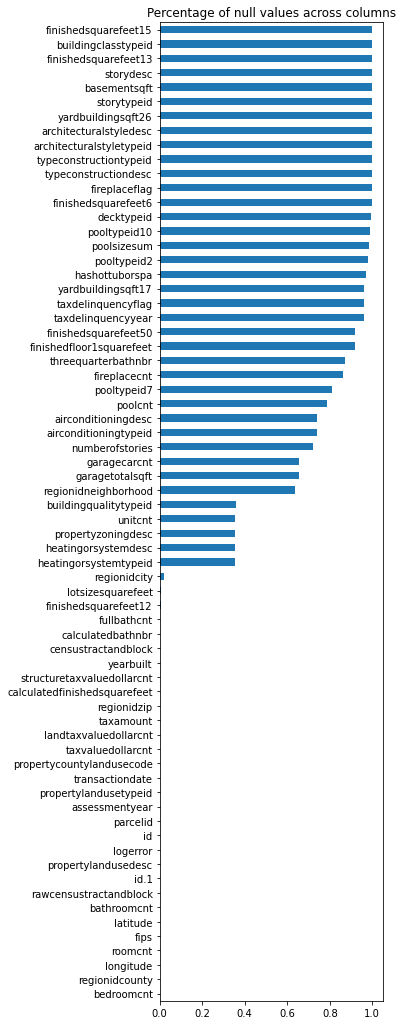

In [4]:
fig = plt.figure(figsize=(4,18))
df.isna().mean().sort_values().plot(kind='barh', title='Percentage of null values across columns')

#### Understanding what is here
To facilitate informed decisions on which columns to keep and which to drop, a data dictionary was created.
| Original Column Name | Renamed Column Name | Status | Notes | Column Description |
|---|---|---|---|---|
| '`airconditioningtypeid`' |  | Dropped | Too many nulls |  Type of cooling system present in   the home (if any) |
| '`architecturalstyletypeid`' |  | Dropped | 99.8% Null |  Architectural style of the home   (i.e. ranch, colonial, split-level, etc…) |
| '`assessmentyear`' |  | Dropped | All values the same | The year of the property tax assessment  |
| '`basementsqft`' |  | Dropped | 99.9% Null |  Finished living area below or   partially below ground level |
| '`bathroomcnt`' |  | Dropped | Duplicates 'calc_bath' |  Number of bathrooms in home   including fractional bathrooms |
| '`bedroomcnt`' |  | Kept |  |  Number of bedrooms in home  |
| '`buildingclasstypeid`' |  | Dropped | 100% Null | The building framing type (steel frame, wood frame, concrete/brick)  |
| '`buildingqualitytypeid`' |  | Dropped | Too many nulls |  Overall assessment of condition of   the building from best (lowest) to worst (highest) |
| '`calculatedbathnbr`' | `calc_bath` | Kept |  |  Number of bathrooms in home   including fractional bathroom |
| '`calculatedfinishedsquarefeet`' | `structure_sqft` | Kept |  |  Calculated total finished living   area of the home  |
| '`censustractandblock`' |  | Dropped | Same data as lat/long + fips |  Census tract and block ID combined   - also contains blockgroup assignment by extension |
| '`decktypeid`' |  | Dropped | 99% Null | Type of deck (if any) present on parcel |
| '`finishedfloor1squarefeet`' |  | Dropped | Too many nulls |  Size of the finished living area   on the first (entry) floor of the home |
| '`finishedsquarefeet12`' |  | Dropped | Same as structure_sqft | Finished living area |
| '`finishedsquarefeet13`' |  | Dropped | 100% Null | Perimeter  living area |
| '`finishedsquarefeet15`' |  | Dropped | 100% Null | Total area |
| '`finishedsquarefeet50`' |  | Dropped | Too many nulls |  Size of the finished living area   on the first (entry) floor of the home |
| '`finishedsquarefeet6`' |  | Dropped | 99% Null | Base unfinished and finished area |
| '`fips`' |  | Kept |  |  Federal Information Processing   Standard code -  see   https://en.wikipedia.org/wiki/FIPS_county_code for more details |
| '`fireplacecnt`' |  | Dropped | Too many nulls |  Number of fireplaces in a home (if   any) |
| '`fireplaceflag`' |  | Dropped | 99.8% Null |  Is a fireplace present in this   home  |
| '`fullbathcnt`' |  | Kept |  |  Number of full bathrooms (sink,   shower + bathtub, and toilet) present in home |
| '`garagecarcnt`' |  | Dropped | Too many nulls |  Total number of garages on the lot   including an attached garage |
| '`garagetotalsqft`' |  | Dropped | Too many nulls |  Total number of square feet of all   garages on lot including an attached garage |
| '`hashottuborspa`' |  | Dropped | Too many nulls |  Does the home have a hot tub or   spa |
| '`heatingorsystemtypeid`' |  | Kept | Nulls imputed as 2 (Central) |  Type of home heating system |
| '`landtaxvaluedollarcnt`' | `tax_land` | Kept | Hoping to use in ensemble model | The assessed value of the land area of the parcel |
| '`latitude`' |  | Kept | Perhaps the most trustworthy datapoint in the set |  Latitude of the middle of the   parcel multiplied by 10e6 |
| '`longitude`' |  | Kept | Perhaps the most trustworthy datapoint in the set |  Longitude of the middle of the   parcel multiplied by 10e6 |
| '`lotsizesquarefeet`' | `lot_sqft` | Kept |  |  Area of the lot in square feet |
| '`numberofstories`' |  | Dropped | Too many nulls |  Number of stories or levels the   home has |
| '`parcelid`' |  | Kept |  |  Unique identifier for parcels   (lots)  |
| '`poolcnt`' |  | Dropped | Too many nulls |  Number of pools on the lot (if   any) |
| '`poolsizesum`' |  | Dropped | Too many nulls |  Total square footage of all pools   on property |
| '`pooltypeid10`' |  | Dropped | 99% Null |  Spa or Hot Tub |
| '`pooltypeid2`' |  | Dropped | Too many nulls |  Pool with Spa/Hot Tub |
| '`pooltypeid7`' |  | Dropped | Too many nulls |  Pool without hot tub |
| '`propertycountylandusecode`' |  | Dropped | Difficult to derive meaning from |  County land use code i.e. it's   zoning at the county level |
| '`propertylandusetypeid`' |  | Dropped | All values the same |  Type of land use the property is   zoned for |
| '`propertyzoningdesc`' |  | Dropped | Too many nulls |  Description of the allowed land   uses (zoning) for that property |
| '`rawcensustractandblock`' |  | Dropped | Same data as lat/long + fips |  Census tract and block ID combined   - also contains blockgroup assignment by extension |
| '`regionidcity`' |  | Kept |  |  City in which the property is   located (if any) |
| '`regionidcounty`' |  | Dropped | Duplicates fips | County in which the property is located |
| '`regionidneighborhood`' |  | Dropped | Too many nulls | Neighborhood in which the property is located |
| '`regionidzip`' |  | Kept |  |  Zip code in which the property is   located |
| '`roomcnt`' |  | Kept |  |  Total number of rooms in the   principal residence |
| '`storytypeid`' |  | Dropped | 99.9% Null |  Type of floors in a multi-story   house (i.e. basement and main level, split-level, attic, etc.).  See tab for details. |
| '`structuretaxvaluedollarcnt`' | `tax_structure` | Kept | Hoping to use in ensemble model | The assessed value of the built structure on the parcel |
| '`taxamount`' |  | Dropped | Leaks data about target variable | The total property tax assessed for that assessment year |
| '`taxdelinquencyflag`' |  | Kept | Made into Boolean with Null imputed as false | Property taxes for this parcel are past due as of 2015 |
| '`taxdelinquencyyear`' |  | Engineered | See 'years_tax_delinquent' | Year for which the unpaid propert taxes were due  |
| '`taxvaluedollarcnt`' | `tax` | Target | This is our target variable | The total tax assessed value of the parcel |
| '`threequarterbathnbr`' |  | Dropped | Too many nulls |  Number of 3/4 bathrooms in house   (shower + sink + toilet) |
| '`typeconstructiontypeid`' |  | Dropped | 99.8% Null |  What type of construction material   was used to construct the home |
| '`unitcnt`' |  | Kept | Nulls imputed as 1 |  Number of units the structure is   built into (i.e. 2 = duplex, 3 = triplex, etc...) |
| '`yardbuildingsqft17`' |  | Dropped | Too many nulls | Patio in  yard |
| '`yardbuildingsqft26`' |  | Dropped | 99.8% Null | Storage shed/building in yard |
| '`yearbuilt`' |  | Kept | Also engineered. See 'age' |  The Year the principal residence   was built  |
|  | `years_tax_delinquent` | Engineered | Nulls imputed as 0 | Calculated by subtacting 'taxdelinquencyyear' from 2017 |
|  | `age` | Engineered |  | Calculated by subtracting 'yearbuilt' from 2017 |
|  | `bathroom_sum` | Engineered |  | Calculated by taking 3/4 of 'threequarterbathnbr' and adding it to   'fullbathcnt' |
| `logerror` |  | Dropped | Leaks data about target variable | Log of the error produced by Zillows existing model |
| `transactiondate` |  | Dropped | Not useful in context of this project | Date of the transaction which zillow's model compared its prediction |                                                 |


#### Saving the columns I can

After diving into each column I was able to come up with a strategy to preserve the data for three of them.
- **`taxdelinquencyflag`**
    - Converted to Boolean where Y = True and Null = False
- **`taxdelinquencyyear`**
    - Created a new column `years_tax_delingquent` by assuming that Nulls == 0 and subtracting the row from 2017 (The year from which this dataset is derived.)
- **`threequarterbathnbr`**
    - Although I didn't actually save the column, I noticed that in some cases there were more threequarter bathrooms than there were bathrooms in the bathroomcnt column.  Hoping that this data might improve my model's accuracy I decided to preserve it by creating a new column: `bathroom_sum`, which is the sum of three quarter bathrooms and full bathrooms.
- **`unitcnt`**
    - An overwhelming majority of rows had the value of "1". So I filled each null with "1".
- **`heatingorsystemdesc`**
    - Similar to `unitcnt`, there was an overwhelming majority of "Central". So I filled each null with "Central" as well.

#### Dropping what I can't

After investigating each column and evaluating whether it could be used or not, a vast majority of them were difficult to trust their accuracy or difficult to find an imputing method that I could be confident in.  As a result, any remaining column with a null percentage higher than 34% was dropped.

Additionally, there were several columns that weren't riddled with nulls but were ultimately unuseful or undesired.  These columns were:
- `id`
- `id.1`
- `assessmentyear`
- `bathroomcnt`
- `finishedsquarefeet12`
- `logerror`
- `propertycountylandusecode`
- `propertylandusedesc`
- `propertylandusetypeid`
- `rawcensustractandblock`
- `censustractandblock`
- `regionidcounty`
- `transactiondate`
- `taxamount`

#### The rest of the nulls
At this point most, but not all, of the data is null free.  To correct that the rows with any remaining nulls were dropped from the dataset.

#### My helper function helps again.

In [5]:
df = wrangle.clean_zillow(df)
df.shape

(50747, 22)

<AxesSubplot:title={'center':'Percentage of null values across columns'}>

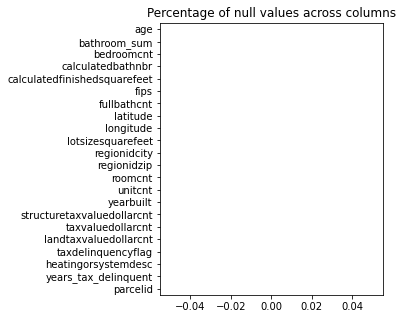

In [6]:
fig = plt.figure(figsize=(4,5))
df.isna().mean().sort_values().plot(kind='barh', title='Percentage of null values across columns')

## Trimming the Data
After handling all of the null values we are left with 50747 rows across 22 columns.  Each row represents a property in Los Angeles and the surrounding area across three different counties.

In [7]:
fig = px.scatter_mapbox(df, lat="latitude", lon="longitude",
                    color="fips", 
                    opacity=.3,
                    size_max=.5, zoom=7)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":20,"t":0,"l":0,"b":0})
fig.update_layout(width=800, height= 700)
fig.show()

### Bad Data (IE. Rabbit hole city)
Still there is a bit more work to do in trimming the data.  In my hunt for outliers I came across a few records that seemed erroneous.  Take for example this row which was the proud owner of the smallest lot size in the dataset.

In [8]:
df[df.lotsizesquarefeet < 400][['parcelid','latitude','longitude','lotsizesquarefeet','calculatedfinishedsquarefeet']]

parcelid   latitude   longitude  lotsizesquarefeet  \
45424  17247439  34.262193 -118.727145                236   

       calculatedfinishedsquarefeet  
45424                          2465

Thankfully location data is included in the dataset so I was able to hunt down the property on Google maps and judge if it really did have such a small lot.  
There is no way that's a 236 sqft lot.  
![image](https://i.imgur.com/gTNnAfU.png)

The dataset is rife with examples like this.  For example, several datapoints have 0 bedrooms.

In [9]:
df[df.bedroomcnt == 0].head()[['parcelid','latitude','longitude','bedroomcnt','calculatedfinishedsquarefeet']]

parcelid   latitude   longitude  bedroomcnt  \
590   11662937  34.036757 -118.519247           0   
3261  11973950  34.124892 -118.201807           0   
4675  12613079  33.790402 -118.313949           0   
6343  17098398  34.369803 -119.059832           0   
8997  12011175  34.101300 -118.327000           0   

      calculatedfinishedsquarefeet  
590                           5782  
3261                           288  
4675                           480  
6343                          2976  
8997                          2350

Again I did some investigating.  I'm going to go out on a limb and assume that that house has more than 0 bedrooms, and probably a lot more than 480 square feet inside.

![image](./images/4MkoGGr.png)

#### Abandoning the rabbit holes
Unfortunately the time alloted for this project is limited, so I decided to stop my investigation there and just accept the fact that I'm probably working with bad data.  However, I want my model to represent reality and not the bad data that it was trained on, so I made some rules to trim out these kinds of data-points.

### The hunt for outliers

I knew walking into this project that there were some pretty offensive outliers in the dataset.  So I wanted to make sure that I trimmed some off.  However, I knew we were going to be training a model on the dataset so it was going to be important to split the data first.  This is to avoid data leakage.

> Note: I realized I made a mistake earlier by hunting down bad data before I split the data, so I later went back and changed my script to apply those rules after the data split happens.

In [10]:
df, _, __ = wrangle.train_test_validate_split(df)
df.shape

(30448, 22)

After splitting the dataset into three groups I'm left with 60% of my original data.  It's on this training data that I will trim outliers and bad data.  However, I will be leaving the other two datasets alone because even though I'm trying to make my model represent reality, it will still be predicting on the bad data in Zilows databases.

I wound up trimming outliers from the following, using the 99th percentile as a cutoff point:
- `taxvaluedollarcnt`
- `calculatedfinishedsquarefeet`
- `lotsizesquarefeet`

In [11]:
df = wrangle.trim_zillow(df)
df.shape

(29526, 22)

That chopped off about 1000 records.

## Exploration

With my data looking how I want it to I have once again utilized my helper functions to make the process easy and reproducible.

In [12]:
train, test, validate = wrangle.wrangle_zillow()
train.shape

(29526, 22)

And finally we are ready to begin exploring the data.  Here it's important to remember the original goals/questions of the project.

#### Question:  
> What are the strongest predictors for property value?

#### Hypothesis:  
> Location, structure size, lot size, age

Let's explore how accurate my hypothesis is.

## How does location affect value?

In [13]:
import plotly.express as px
fig = px.scatter_mapbox(train, lat="latitude", lon="longitude", color="tax", 
                    # size='structure_sqft',
                    color_continuous_scale=px.colors.sequential.Plasma, size_max=15, zoom=8)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":20,"t":0,"l":0,"b":0})
fig.update_layout(width=800, height= 700)
fig.show()

#### Takeaways
There are definitely some hotspots as well as some cold spots, but I can see that a majority of the properties fall within 0.5M to 1M range.

However, the location data won't play nicely with a linear regression model so we can't use it for now.  
A possible way forward would be to use clustering to group these into categories (hotspot/not-hotspot).

## How does structure sqft affect structure value ?

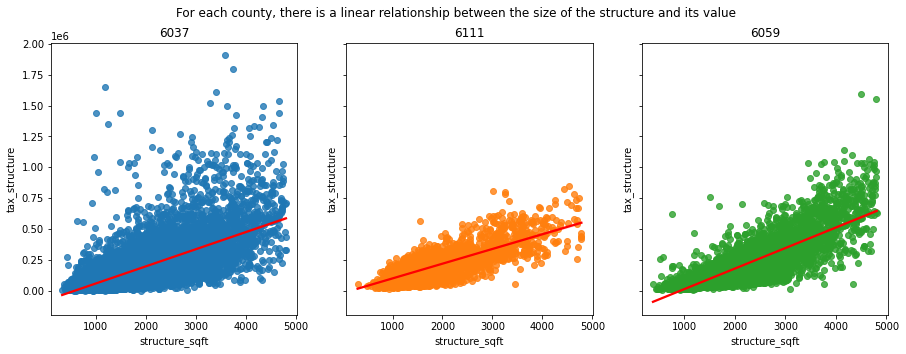

In [14]:
fig, ax = plt.subplots(1,3, figsize=(15,5), sharey=True)
fig.suptitle('For each county, there is a linear relationship between the size of the structure and its value')
palette = sns.color_palette()
fipList = train.fips.unique().tolist()
for i, fip in enumerate(fipList):
    sns.regplot(data=train[train.fips == fip], x='structure_sqft', y='tax_structure',
    color=palette[i],
    ax=ax[i],
    line_kws={'color':'red'})
    ax[i].set_title(fip)

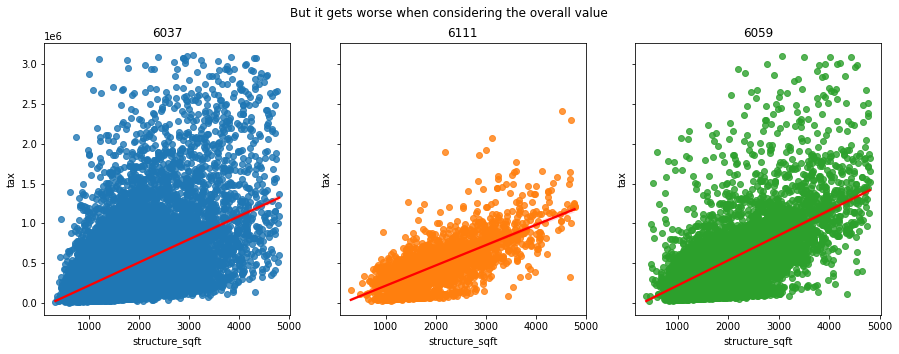

In [15]:
fig, ax = plt.subplots(1,3, figsize=(15,5), sharey=True)
fig.suptitle('But it gets worse when considering the overall value')
palette = sns.color_palette()
fipList = train.fips.unique().tolist()
for i, fip in enumerate(fipList):
    sns.regplot(data=train[train.fips == fip], x='structure_sqft', y='tax',
    color=palette[i],
    ax=ax[i],
    line_kws={'color':'red'})
    ax[i].set_title(fip)

#### Takeaways
There is a clear linear relationship between the structure's size and its value.  However when considering the overall value (`tax_structure` + `tax_land`) it seems to fall apart slightly.

## How does the lot's sqft affect land value ?

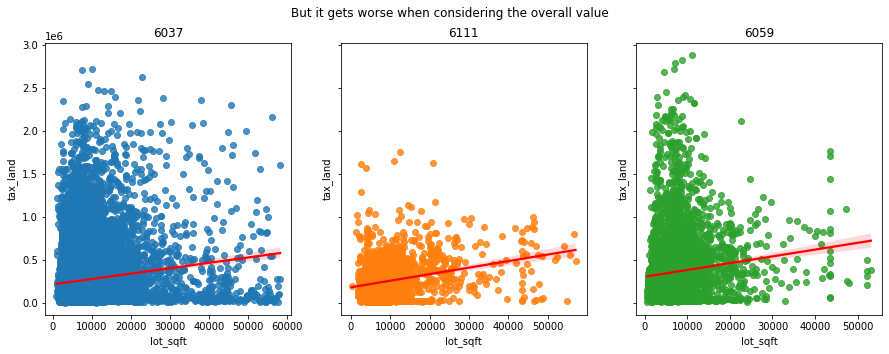

In [16]:
fig, ax = plt.subplots(1,3, figsize=(15,5), sharey=True)
fig.suptitle('But it gets worse when considering the overall value')
palette = sns.color_palette()
fipList = train.fips.unique().tolist()
for i, fip in enumerate(fipList):
    sns.regplot(data=train[train.fips == fip], x='lot_sqft', y='tax_land',
    color=palette[i],
    ax=ax[i],
    line_kws={'color':'red'})
    ax[i].set_title(fip)

#### Takeaways
There doesn't seem to be a strong relationship here at all, which is surprising to me.  This means that we will need to find some other way to predict this side of the equation.

## How does structure value affect overall value?

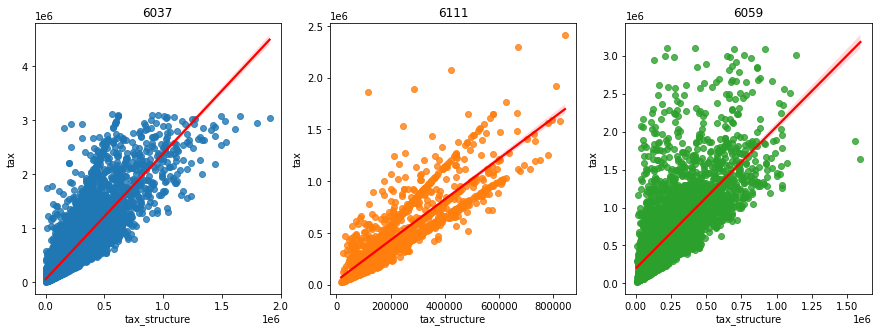

In [17]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
palette = sns.color_palette()
fipList = train.fips.unique().tolist()
for i, fip in enumerate(fipList):
    sns.regplot(data=train[train.fips == fip], x='tax_structure', y='tax',
    color=palette[i],
    ax=ax[i],
    line_kws={'color':'red'})
    ax[i].set_title(fip)

#### Takeaways:
I can see a very strong linear relationship between the home's assesed value and the overall value for the property.  In fact, I can actually see some lines formed from the datapoints themselves, especially for FIPS 6111.

### Statistical Sanity check

### Is structure square footage a strong correlator to structure tax value?

`Null Hypothesis` : No correlation  
`Alternate Hypothesis`: Yes correlation

Text(0.5, 0.98, 'Distributions are parametric')

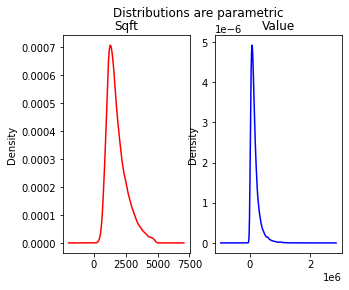

In [18]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (5,4))
train.structure_sqft.plot.kde(color='red', label='age', ax=ax1, title='Sqft')
train.tax_structure.plot.kde(color='blue', label='age', ax=ax2, title='Value')
fig.suptitle('Distributions are parametric')

Because the distributions are parametric we can use Pearsons-R correlation test.

In [19]:
r, p = stats.pearsonr(train.structure_sqft, train.tax_structure)
print(f'There is a {r:.2%} linear correlation between the variables with a {p:.2%} probability that the correlation was due to random chance.')

There is a 73.75% linear correlation between the variables with a 0.00% probability that the correlation was due to random chance.


> **Takeaway:**  
> Structure square footage is a strong predictor for predicting the tax value of the structure.

### Is structure tax value a strong correlator to total tax value?

`Null Hypothesis` : No correlation  
`Alternate Hypothesis`: Yes correlation

Text(0.5, 0.98, 'Distributions are parametric')

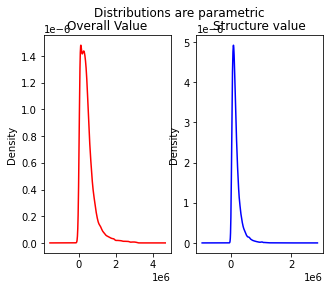

In [20]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (5,4))
train.tax_structure.plot.kde(color='blue', label='age', ax=ax2, title='Structure value')
train.tax.plot.kde(color='red', label='age', ax=ax1, title='Overall Value')
fig.suptitle('Distributions are parametric')

Because the distributions are parametric we can use Pearsons-R correlation test.

In [21]:
r, p = stats.pearsonr(train.tax, train.tax_structure)
print(f'There is a {r:.2%} linear correlation between the variables with a {p:.2%} probability that the correlation was due to random chance.')

There is a 79.35% linear correlation between the variables with a 0.00% probability that the correlation was due to random chance.


> **Takeaway:**  
> Structure tax value is a strong predictor for predicting the overall value of the property.

## Exploration Summary  

During exploration I discovered:
- The structure's square footage is a better predicter for the structure's tax value than it is for the overall tax value
- The land's square footage is not a very good predictor for the land's tax value.
- The structure's tax value is a eerily good predictor for the overall tax value, Though perhaps the FIPS code is not a narrow enough subset to capture the different rules used by tax assessors.
- Each FIPS code has slightly different correlations between predictors and target values.

With these discoveries in mind I should be able to create a decent linear regression model from a single feature.

## Modeling

Based on my discoveries during exploration I was be able to create a decent model from a single variable.  The code for creating and evaluating it has been wrapped in a helper library (`model.py`)

The model I created is technically two models working in concert with one another.  This type of setup is called an Ensemble.  It works by first predicting the strucure's tax value from the square footage of the home, then it attempts to predict the overall value based off of the predictions of the first model.

I'll try to show off it's performance here.

First we want to collect our X and Y splits

In [22]:
x_train = model.reshape_series(train.structure_sqft)
y_train = train.tax
x_test = model.reshape_series(test.structure_sqft)
y_test = test.tax
x_validate = model.reshape_series(validate.structure_sqft)
y_validate = validate.tax

And then we can use our helper library to make some predictions.

In [23]:
train_pred = model.ensemble_predict(x_train)
test_pred = model.ensemble_predict(x_test)
validate_pred = model.ensemble_predict(x_validate)

Evaluate the predictions.

In [24]:
train_pred_RMSE = mean_squared_error(y_train, train_pred, squared=False)
test_pred_RMSE = mean_squared_error(y_test, test_pred, squared=False)
validate_pred_RMSE = mean_squared_error(y_validate, validate_pred, squared=False)

Collect baseline predictions as well.

In [25]:
train_base = model.train_baseline_match_len(y_train)
test_base = model.train_baseline_match_len(y_test)
validate_base = model.train_baseline_match_len(y_validate)

train_base_RMSE = mean_squared_error(y_train, train_base, squared=False)
test_base_RMSE = mean_squared_error(y_test, test_base, squared=False)
validate_base_RMSE = mean_squared_error(y_validate, validate_base, squared=False)

Throw it all into a dataframe

In [27]:
df = pd.DataFrame(columns=["baseline_RMSE", "predicted_RMSE"], index=['Train','Test','Validate'] ,
                    data=[[train_base_RMSE,train_pred_RMSE],
                            [test_base_RMSE,test_pred_RMSE],
                            [validate_base_RMSE,validate_pred_RMSE]])
df['percent'] = df.predicted_RMSE / df.baseline_RMSE
df

baseline_RMSE  predicted_RMSE   percent
Train     411724.406790   342038.749846  0.830747
Test      619819.000917   492008.595217  0.793794
Validate  732305.113763   596437.402671  0.814466

As you can see, my model doesn't perform much better than the baseline.

# Conclusion

The preparation and cleaning of the data was by far the most difficult part of the project for me.